# Simulator

A basic simulator for sanity checking the design and tweaking parameters. We're going to be a few simplifications of the friction (viscous damping) and the fluid flow (incompressible, laminar).

This should help us get the design into the right order of magnitude.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [57]:
%matplotlib notebook

In [2]:
#common conversions
psi_to_pa = 6894.76

In [229]:
#constants
HIGH_PRESSURE_SOURCE=100*psi_to_pa #[Pa]
P_ATM = 15*psi_to_pa # [Pa]
PISTON_DIA=20 #[mm]
STROKE=10 #[mm]
FLYWHEEL_DIA=45 #[mm]
FLYWHEEL_WIDTH=30 #[mm]
STEEL_DENSITY=7850 #[kg/m3]

## Rotational Moment of Inertia:

Calculate the intertia of the flywheel:

![rotational inertia formula](figures/rotational_inertia.png) 

In [230]:
flywheel_volume=np.pi*(FLYWHEEL_DIA/2)**2*FLYWHEEL_WIDTH*1e-3**3
I = 0.5*(flywheel_volume*STEEL_DENSITY)*(FLYWHEEL_DIA/2)**2*1e-3**2 #kg*m^2
print(f"The flywheel's moment of inertia is: {I} [kg*m^2]")

The flywheel's moment of inertia is: 9.480709968257266e-05 [kg*m^2]


In [166]:
flywheel_volume

1.590431280879833e-05

Recall:

$ torque = force * radius $\
$ force = mass * acceleration $\
$ torque = inertia * angular\ acceleration $

Let's use these formulas, an initial velocity and a random friction value to start making some simple simulations

In [203]:
omega = 1 #rev/s

# model friction as damping. Ff = -k * omega
# I played with this value until it gave me a result that seemed reasonable.
# I imagined myself spinning the motor by hand, and measuring how long it would take until it comes to a stop.
# I imagine you wouldn't be able to get much more than ~ 10 revolutions.
k = 1e-8

dt = 1e-2 # [s]. Timestep for our simulation
t_end = 10 # [s]. Length of simulation

t = np.arange(0, t_end, dt)
omega_arr = np.empty(len(t))
for i in range(len(t)):
    Ff = -k*omega
    alpha = Ff/I
    
    # Forwards Euler timestepping
    # if our equations are costly, we can 
    # do a higher order timestepping to maintain accuracy but use
    # a higher dt.
    omega += alpha*dt
    
    #store the values
    omega_arr[i] = omega

<IPython.core.display.Javascript object>


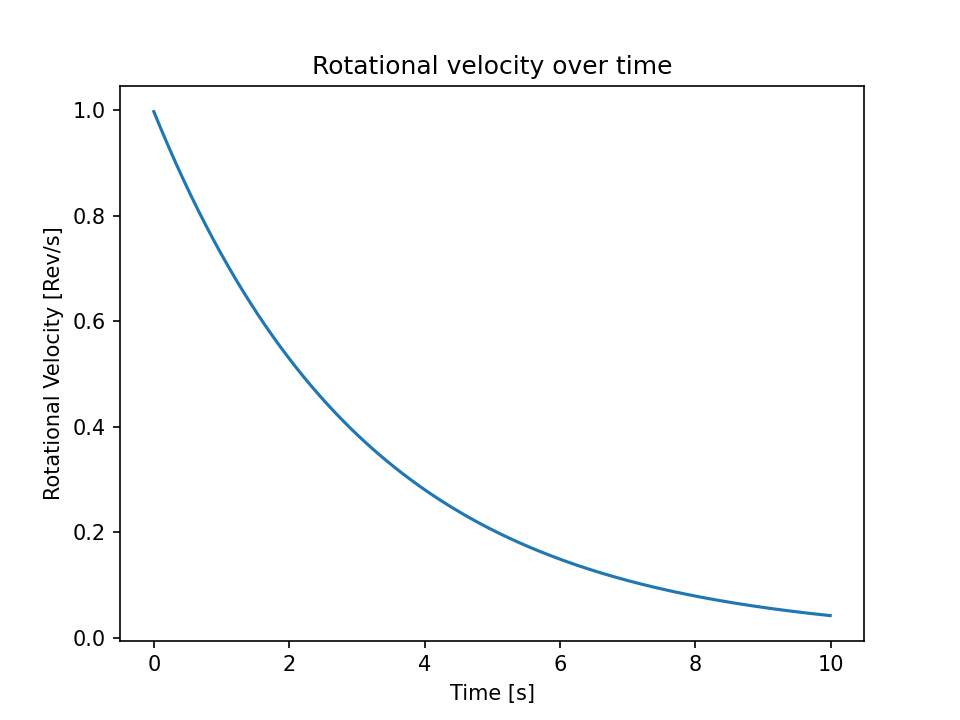

In [204]:
fig, ax = plt.subplots()
ax.plot(t, omega_arr)
ax.set_title("Rotational velocity over time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Rotational Velocity [Rev/s]");

The velocity decaying over time matches our expectations. Try changing the value of the friction to see the effect.

# Darcy-Weisbach Equation

The next piece of the puzzle is the Darcy-Weisbach equation. This will allow us to calculate the change in pressure of the piston. A flow restriction between the high pressure source and the cylinder is necessary so we do not build up too much pressure too early on the upwards stroke. 

The Darcy-Weisbach equation is an empirical formula that calculates the pressure drop due to friction for incompressible fluid flow in a pipe \[1].

$\frac{\Delta p}{L} = f_D \frac{\rho}{2}\frac{v}{D}$

Where:\
$\Delta p$ is the delta of the pressure between point A and point B [Pa]\
$L$ is the length of the pipe [m]\
$f_D$ is the friction factor. For laminar flow it is $f_D = 64/Re$\
$\rho$ is the density\
$v$ is the mean flow velocity

The above can be re-written for a circular pipe, laminar flow and volumetric flow rate:

$\frac{\Delta p}{L} = \frac{128}{\pi}\frac{\mu Q}{D^4}$

Where:\
$\mu$ is the dynamic viscosity [kg/(m·s)]\
$Q$ is the volumetric flow rate: [m^3/s]

One thing to note is that we can certainly confirm that the fluid is compressible as that is the whole point of what we are doing. However, for now we are going to ignore this and carry on. We'll be sure to write this section as a function so different models can easily be swapped and evaluated if necessary.

\[1]: https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation

We assume the high pressure air supply is infinite. Given a volume and starting pressure of the cyclinder we can use the ideal gas law to calculate the change in pressure given the flow rate.

$p V =n R T$

We are assuming isothermal operation, so T is constant

The change in n (number of molecules, moles) can be calculated using the density (which varies with pressure) and the volumetric flow rate.

density air: 1.225 kg/m^3 # At atmospheric pressure. Assume this changes linearly with pressure
gas constant: 287.05 [j/(kg·K)]

In [186]:
D = 0.5e-3 # [m]
L = 30e-3 # [m]
mu = 1.81e-5 # [kg/(m·s)]
T = 25 + 273.15 # [K]
R = 287.05 # [(m^3·Pa)/(kg·K)]

# Initial value of the piston pressure
piston_p = P_ATM #[Pa]

h = 10 # [mm] height of piston from top
def piston_volume(h):
    return np.pi * (PISTON_DIA/2)**2 * h * (1e-3)**3 # [m^3]

def rho(p):
    return 1.225*p/P_ATM # [kg/m^3]

def volumetric_flow_rate(p):
    #args: pressure in the low volume cavity (piston)
    return (HIGH_PRESSURE_SOURCE-p)/L*(np.pi/128)*(D**4/mu) # m^3/s

n = piston_p*piston_volume(h)/(R*T) # calculate the initial mass of the gas in the piston


dt = 1e-3 # [s]. Timestep for our simulation
t_end = 10e-3 # [s]. Length of simulation

t = np.arange(0, t_end, dt)
piston_p_arr = np.empty(len(t))
for i in range(len(t)):
    Q = volumetric_flow_rate(piston_p)
    
    # Forward Euler timestepping
    # if our equations are costly, we can 
    # do a higher order timestepping to maintain accuracy but use
    # a higher dt. Or we could do backwards euler to guarentee stability
    n += Q*dt*rho(piston_p)
    piston_p = n*R*T/piston_volume(h)
    
    #store the values
    piston_p_arr[i] = piston_p

<IPython.core.display.Javascript object>


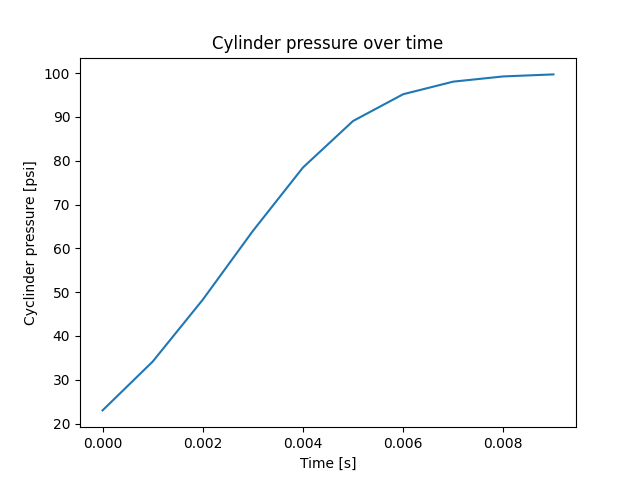

In [187]:
fig, ax = plt.subplots()
ax.plot(t, piston_p_arr/psi_to_pa)
ax.set_title("Cylinder pressure over time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Cyclinder pressure [psi]");

This matches what we would expect to see. Asymptotically approaching the pressure of the source. I don't much intuition on how quickly we should expect the cylinder to reach equilibrium pressure, but this seems to be on the fast side.

For now we can just artificially increase the flow restriction until we acheive something we are happy with.

## Put everything together to make the engine run.

There are 3 different modes we operate under. 

1. Piston is open to atmosphere. Only friction will be acting to slow down the rotational velocity
2. Closed. The gas inside the cylinder is only changing pressure due to a change in volume.The velocity change depends on the direction of travel.
3. Piston is open to high pressure source. The pressure in the cyclinder will be changing due to the change in volume, and the flow in to the piston. Hopefully we can configure things such that there will be a net positive force increasing our velocity.

In [236]:
# Additional design constants
H_HPA = 10 # [mm]. The height at which the high pressure air is connected
H_ATM = 17 # [mm]. The height at which the piston becomes connected to the atmosphere
PISTON_DEADSPACE = 2 # [mm]

# Initial values
piston_p = P_ATM #[Pa]
theta=0.1 # [radians]. Crank angle
omega=1# [rad/s]

#derived values:
h = np.cos(theta)*STROKE-STROKE
n = piston_p*piston_volume(h+PISTON_DEADSPACE)/(R*T)

dt = 1e-5 # [s]. Timestep for our simulation
t_end = 0.1 # [s]. Length of simulation

t = np.arange(0, t_end, dt)

#values we want to save for plotting
piston_p_arr = np.empty(len(t))
theta_arr = np.empty(len(t))
omega_arr = np.empty(len(t))
alpha_arr = np.empty(len(t))

for i in range(len(t)):
    # First calculate the height of the piston in the cylinder:
    h = -np.cos(theta)*STROKE+STROKE
        
    # update the piston pressure appropriately according to the 
    # mode we are operating in:
    if h < H_HPA:
        #we are connected to the air supply
        Q = volumetric_flow_rate(piston_p) #[m^3/s]
        n += Q*dt*rho(piston_p)
        piston_p = n*R*T/piston_volume(h+PISTON_DEADSPACE)
    elif h < H_ATM:
        # We are closed off        
        piston_p = n*R*T/piston_volume(h+PISTON_DEADSPACE)
        #note, we are not updating the number of gas molecules in the chamber because
        #it is a closed system now.
    else:
        piston_p = P_ATM
        n = piston_p*piston_volume(h+PISTON_DEADSPACE)/(R*T)

    #calculate the net force on the piston given the pressure differential
    F_piston = np.pi*(PISTON_DIA/2)**2*(1e-3**2)*(piston_p-P_ATM)
    T_piston = F_piston * np.sin(theta)*STROKE*1e-3

    #calculate the force of friction given the rotational velocity
    Tf = -k*omega
    
    #calculate the instantaneous acceleration
    alpha = (Tf + T_piston)/I
    
    # update the values of interest
    omega += alpha*dt
    theta += omega*dt
 
    #store the values of interest
    piston_p_arr[i] = piston_p
    theta_arr[i] = theta
    omega_arr[i] = omega
    alpha_arr[i] = alpha

<IPython.core.display.Javascript object>


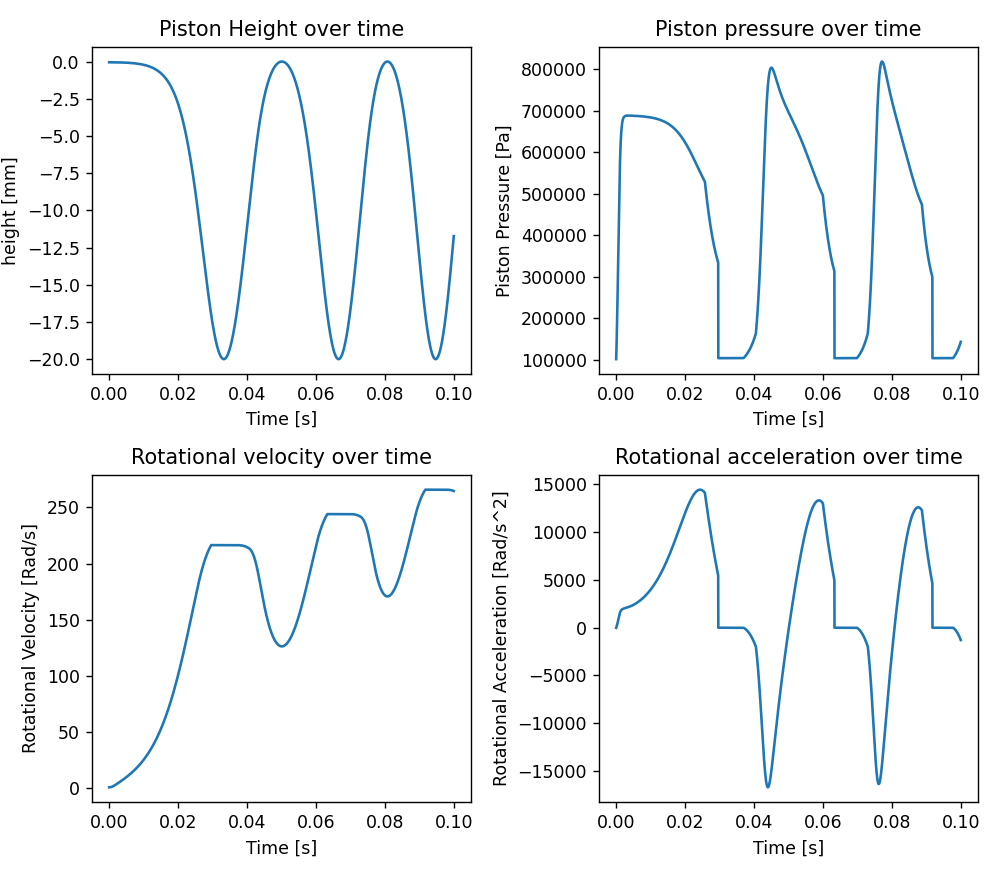

In [237]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

ax[0, 0].plot(t, np.cos(theta_arr)*STROKE-STROKE)
ax[0, 0].set_title("Piston Height over time")
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("height [mm]");

ax[0, 1].plot(t, piston_p_arr)
ax[0, 1].set_title("Piston pressure over time")
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Piston Pressure [Pa]");

ax[1, 0].plot(t, omega_arr)
ax[1, 0].set_title("Rotational velocity over time")
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("Rotational Velocity [Rad/s]");

ax[1, 1].plot(t, alpha_arr)
ax[1, 1].set_title("Rotational acceleration over time")
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel("Rotational Acceleration [Rad/s^2]");



fig.tight_layout()

We can see the simulator does in fact show reasonable results. The accuracy of them is not known however.